# チャンネルブレイクアウト戦略！！！！！！

In [1]:
import datetime
from math import floor
import pprint
import schedule
from statistics import mean
from statistics import median
from statistics import StatisticsError
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.pricing as pricing
from oandapyV20.endpoints.pricing import PricingInfo
from oandapyV20.contrib.requests import (MarketOrderRequest, StopLossDetails)
import oandapyV20.endpoints.forexlabs as labs

sys.path.append('../')
from oandapyV21 import *

# OANDA API v20の口座IDとAPIトークン(ドル円) py703413
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"

## BT1
単純なN期間内最高値、最安値をブレイクしたらドテン

In [19]:
# バックテスト
def back_test(df, fee, seed_money, n=10, lot=1000, kly_rate='None', print_=True):
    pos = 'None'
    assets = seed_money
    tmp_i = 0
    lot_l = []
    l_or_s = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []

    # 実行
    for i in range(n, len(df)-1):
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値
        high_l = []
        low_l = []
        for j in range(n):
            high_l.extend([df.iat[i-j-1, 3]])
            low_l.extend([df.iat[i-j-1, 4]])
        highest = max(high_l)
        lowest = min(low_l)
    
        # 上昇トレンドと判断しロング
        if df.iat[i, 5] > highest:
            if pos == 'entry_long':
                continue
            else:
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_short':
                    exit_rate = next_rate
                    pips = (entry_rate - exit_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    l_or_s.extend(['short'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_long'
                tmp_i = i
        
        # 下降トレンドと判断しショート
        if df.iat[i, 5] > lowest:
            if pos == 'entry_short':
                continue
            else:
                # もし逆のポジションを持ってたら利確
                if pos == 'entry_long':
                    exit_rate = next_rate
                    pips = (exit_rate - entry_rate - fee) * 100
                    if kly_rate != 'None':
                        kly = assets * kly_rate
                        lot = floor(kly / exit_rate)
                    profit = pips * lot / 100
                    assets = round(assets + profit, 4)
                    lot_l.extend([lot])
                    l_or_s.extend(['long'])
                    entry_date.extend([df.iat[tmp_i, 0]])
                    entry_rate_l.extend([entry_rate])
                    exit_date.extend([df.iat[i, 0]])
                    exit_rate_l.extend([exit_rate])
                    pips_l.extend([pips])
                    profit_l.extend([profit])
                    assets_l.extend([assets])
                    if assets < 0:
                        break
                entry_rate = next_rate
                pos = 'entry_short'
                tmp_i = i
    
    pos_df = pd.DataFrame(data={'lot': lot_l, 'l_or_s': l_or_s, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df

### 通貨ペアと足と参照本数の検証

In [22]:
# スプレッド取得
sp = {}
for inst in all_inst():
    sp[inst] = pip_spread(inst)[2]

In [23]:
# スプレッド出力
pd.DataFrame(data=sp.items(), columns=['instrument', 'spread']).to_csv('spreads.csv', index=False)
# sp = pd.read_csv('spreads.csv').to_dict()

In [28]:
# 足検証
inst_df = pd.DataFrame(columns=['instrument', 'gran', 'n', 'pos_count', 'profit',
                                'WP(%)', 'POR', 'PF', 'E(円)', 'DD(%)', 'KLY(%)'])
grans = ['M30', 'H1', 'H2', 'H3', 'H4', 'H6', 'H8', 'H12', 'D']
grans.reverse()
for inst in all_inst()[18:]:
    print('{} start'.format(inst))
    for gran in grans:
        df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', gran, inst)
        for n in range(5, 55, 5):
#             print('inst: {}, gran: {:>3}, n: {:>2}, '.format(inst, gran, n), end='')
            pos_df = back_test(df, fee=sp[inst], seed_money=1000000, n=n, print_=False)
            pos_count, profit = pos_df.shape[0], pos_df['pips'].sum() / 100
            WP, POR, PF, E, DD, KLY = get_evaluation(pos_df, return_=True)
#             print('pos count: {:>8}, profit: {:>10.3f}'.format(pos_count, profit))
            tmp_se = pd.Series([inst, gran, n, pos_count, profit, WP, POR, PF, E, DD, KLY], index=inst_df.columns)
            inst_df = inst_df.append(tmp_se, ignore_index=True)
            inst_df.to_csv('inst_df.csv', index=False)

USD_SAR start
CHF_HKD start
EUR_NZD start
USD_THB start
GBP_CHF start
TRY_JPY start
USD_PLN start
GBP_AUD start
EUR_SGD start
CHF_JPY start
USD_INR start
EUR_SEK start
USD_SGD start
USD_DKK start
EUR_TRY start
USD_JPY start
GBP_PLN start
USD_HKD start
NZD_SGD start
GBP_ZAR start
ZAR_JPY start
EUR_AUD start
HKD_JPY start
CAD_SGD start
USD_NOK start
USD_CZK start
GBP_NZD start
EUR_DKK start
AUD_JPY start
USD_CAD start
USD_HUF start
EUR_CZK start
AUD_HKD start
CHF_ZAR start
EUR_USD start
USD_TRY start
GBP_JPY start
EUR_CAD start
CAD_HKD start
USD_MXN start
GBP_USD start
SGD_CHF start
CAD_CHF start
USD_CHF start
AUD_SGD start
EUR_NOK start
EUR_CHF start
EUR_HKD start
NZD_USD start
AUD_USD start
SGD_JPY start
AUD_CAD start
AUD_CHF start


In [30]:
inst_df = pd.read_csv('inst_df.csv')
# inst_df.to_csv('inst_df.csv', index=False)

In [31]:
inst_df.sort_values(by='profit', ascending=False).head(50)

,instrument,gran,n,pos_count,profit,WP(%),POR,PF,E(円),DD(%),KLY(%)
459,TRY_JPY,D,50,164,27.86800,7.32,21.1683,1.6712,169.927,1.90,2.94
458,TRY_JPY,D,45,180,25.94100,7.78,18.6726,1.5748,144.117,1.92,2.84
457,TRY_JPY,D,40,192,24.47800,7.81,17.7082,1.5007,127.490,1.97,2.61
455,TRY_JPY,D,30,230,23.59400,8.70,15.1346,1.4414,102.583,2.13,2.66
456,TRY_JPY,D,35,202,22.77700,7.92,16.7638,1.4420,112.757,2.02,2.43
454,TRY_JPY,D,25,270,19.25800,9.63,12.3223,1.3130,71.326,2.23,2.30
453,TRY_JPY,D,20,320,15.60900,9.69,11.3740,1.2200,48.778,2.37,1.75
469,TRY_JPY,H12,50,342,14.13200,7.60,14.6365,1.2043,41.322,2.50,1.29
452,TRY_JPY,D,15,368,13.57900,10.87,9.6145,1.1725,36.899,2.56,1.60
468,TRY_JPY,H12,45,374,10.99200,8.02,13.1686,1.1484,29.390,2.55,1.04


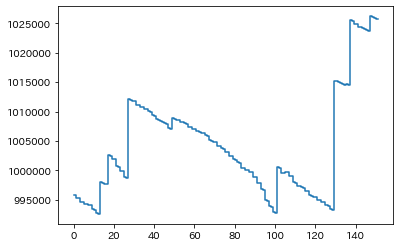

In [33]:
inst = 'TRY_JPY'
df = get_data_super('2010-01-01-00-00-00', '2020-01-01-00-00-00', 'D', inst)
pos_df = back_test(df, fee=sp[inst], seed_money=1000000, n=60, print_=False)
plt.plot(pos_df['assets'], ds='steps')
plt.show()

## BT2